In [1]:
from darts.models import StatsForecastAutoETS, StatsForecastAutoARIMA, StatsForecastAutoTheta
from utility import ForecastingManager
from darts.models.forecasting.lgbm import LightGBMModel

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/home/mahdi/anaconda3/envs/darts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notes
This code should be able to automatically fit different models on different datasets. 

The main data structure will be a list of dictionaries, where each element of the list corresponds to a model-dataset pair and has the following format.

{<br>
    dataset_name:str,<br>
    model_name:str,<br>
    train_data:TimeSeries,<br>
    test_data:TimeSeries,<br>
    test_data_pred:TimeSeries,<br>
    summary_errors:{'MAPE':float}<br>
}

Regression models, such as LightGBM, accept both future and past covariates. 
So for now I will stick to that model only.

Next: LightGBM with past and future covariates.

### Item 2: Four models: SFAutoTheta, SFAutoETS, SFAutoARIMA, LightGBM on the temperature anomaly + air quality dataset

In Darts, SFAutoETS, SFAutoARIMA take only future covariates. SFAutoTheta does not take any covariates. [https://unit8co.github.io/darts/userguide/covariates.html]

In [3]:
# Example usage
forecasting_manager = ForecastingManager()
forecasting_manager.add_model_data_pair(model=StatsForecastAutoARIMA(season_length=12),
                                        dataset_address='datasets/retail/air_passengers.csv', 
                                        time_col_name='ds',                                         
                                        target_col_name='y')

forecasting_manager.add_model_data_pair(model=StatsForecastAutoTheta(season_length=12),
                                        dataset_address='datasets/retail/air_passengers.csv', 
                                        time_col_name='ds',                                         
                                        target_col_name='y')

forecasting_manager.add_model_data_pair(model=StatsForecastAutoETS(season_length=12, model="AZZ"),
                                        dataset_address='datasets/retail/air_passengers.csv', 
                                        time_col_name='ds',                                         
                                        target_col_name='y')

# Get and print the results
entries_and_results = forecasting_manager.get_entries_and_results()
print(entries_and_results[0].keys())

dict_keys(['model', 'df_address', 'df', 'target_series', 'covariates', 'eval_metric_funcs', 'summary_errors'])


In [4]:
entries_and_results[0]['model'].__class__.__name__

'StatsForecastAutoARIMA'

In [5]:
for curr_entry_and_results in entries_and_results:
    cer = curr_entry_and_results
    
    print(f"Now fitting, {cer['model'].__class__.__name__} on {cer['df_address']}.")
    cer['model'].fit(cer['target_series']['train'])
    
    num_test = len(cer['target_series']['test'])

    cer['target_series']['test_preds'] = cer['model'].predict(num_test)

    print(f"calculating and adding errors")
    for a_func in cer['eval_metric_funcs']:        
        cer['summary_errors'][a_func.__name__] = \
            a_func(cer['target_series']['test'], cer['target_series']['test_preds'])
    

Now fitting, StatsForecastAutoARIMA on datasets/retail/air_passengers.csv.
calculating and adding errors
Now fitting, StatsForecastAutoTheta on datasets/retail/air_passengers.csv.
calculating and adding errors
Now fitting, StatsForecastAutoETS on datasets/retail/air_passengers.csv.
calculating and adding errors


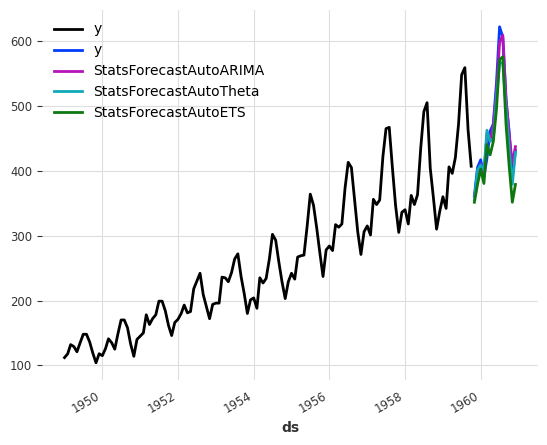

In [17]:
curr_entry_and_results['target_series']['train'].plot(new_plot=True)
curr_entry_and_results['target_series']['test'].plot(new_plot=False)
for curr_entry_and_results in entries_and_results:
    cer = curr_entry_and_results
    label = cer['model'].__class__.__name__
    curr_entry_and_results['target_series']['test_preds'].plot(new_plot=False, label=label)
    

In [18]:
for curr_entry_and_results in entries_and_results:
    print([curr_entry_and_results[key] for key in ['model', 'summary_errors']])

[StatsForecastAutoARIMA(add_encoders=None, season_length=12), {'mape': 2.4539197689384014}]
[StatsForecastAutoTheta(season_length=12), {'mape': 4.068928285183017}]
[StatsForecastAutoETS(add_encoders=None, season_length=12, model=AZZ), {'mape': 6.831571532952071}]
